In [1]:
%matplotlib inline

import os
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import scipy.sparse as sparse
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

sys.path.append('../../../Code/')
from utils import read_dataset_log, starcat

In [2]:
from matplotlib import rcParams, font_manager

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#rcParams['text.usetex'] = True


In [3]:
figdir = '../../../Figures/Components'

# Download data

Download pancancer data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE210347

In [18]:
! wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE210nnn/GSE210347/suppl/GSE210347%5Fcounts.Rds.gz

--2024-02-20 19:24:30--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE210nnn/GSE210347/suppl/GSE210347%5Fcounts.Rds.gz
Resolving ftp.ncbi.nlm.nih.gov... 130.14.250.13, 130.14.250.12, 2607:f220:41e:250::13, ...
Connecting to ftp.ncbi.nlm.nih.gov|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2594158732 (2.4G) [application/x-gzip]
Saving to: “GSE210347_counts.Rds.gz”

100%[====================================>] 2,594,158,732 9.07M/s   in 4m 36s  

2024-02-20 19:29:06 (8.96 MB/s) - “GSE210347_counts.Rds.gz” saved [2594158732/2594158732]



In [29]:
! wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE210nnn/GSE210347/suppl/GSE210347_meta.txt.gz

--2024-02-21 09:04:33--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE210nnn/GSE210347/suppl/GSE210347_meta.txt.gz
Resolving ftp.ncbi.nlm.nih.gov... 130.14.250.12, 130.14.250.13, 2607:f220:41e:250::7, ...
Connecting to ftp.ncbi.nlm.nih.gov|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19366095 (18M) [application/x-gzip]
Saving to: “GSE210347_meta.txt.gz”

100%[======================================>] 19,366,095  8.12M/s   in 2.3s    

2024-02-21 09:04:36 (8.12 MB/s) - “GSE210347_meta.txt.gz” saved [19366095/19366095]



In [4]:
if not os.path.exists('../../../Data/PerDataset/Pancancer/LuoEtAl_Full'):
    os.mkdir('../../../Data/PerDataset/Pancancer/LuoEtAl_Full')

In [22]:
! mv GSE210347_counts.Rds.gz ../../../Data/PerDataset/Pancancer/LuoEtAl_Full/

In [23]:
! gzip -d ../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.Rds.gz

In [30]:
! mv GSE210347_meta.txt.gz ../../../Data/PerDataset/Pancancer/LuoEtAl_Full/

In [31]:
! gzip -d ../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_meta.txt.gz

# Extract % of cell types

In [5]:
metafn = '../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_meta.txt'
meta = pd.read_csv(metafn, sep='\t')

In [6]:
meta.head()

,cellname,nCount_RNA,nFeature_RNA,SampleID,percent.mt,seurat_clusters,cluster,celltype,tissue,group
0,1_nature_AscendingColon1_AACCTATAGCATACCTGA,2095,446,1_nature_AscendingColon1,6.252983,39,c29,Plasma,colorectal,Normal
1,1_nature_AscendingColon1_ACGTTGTGCAATTTCATA,2557,686,1_nature_AscendingColon1,10.715682,32,c16,Lymphocyte,colorectal,Normal
2,1_nature_AscendingColon1_CTCGCAACTTATGACACT,2385,686,1_nature_AscendingColon1,7.085954,41,c31,Plasma,colorectal,Normal
3,1_nature_AscendingColon1_CTCGCACAACAAACCTGA,2799,644,1_nature_AscendingColon1,4.358700,41,c31,Plasma,colorectal,Normal
4,1_nature_AscendingColon1_CTCGCACTCCATCAACAA,2374,604,1_nature_AscendingColon1,7.371525,41,c31,Plasma,colorectal,Normal


In [7]:
all_cell_type_counts = meta['celltype'].value_counts()
all_cell_types = all_cell_type_counts.index

In [8]:
meta['group'].value_counts()

Tumor       494610
Adjacent    194331
Normal      166330
Name: group, dtype: int64

In [9]:
(pd.crosstab(meta['SampleID'], meta['group'])>0).sum(axis=1).max()

1

In [10]:
(pd.crosstab(meta['SampleID'], meta['tissue'])>0).sum(axis=1).max()

1

In [10]:
allresults = []
for samp, sampdata in meta.groupby('SampleID'):
    tissue = sampdata['tissue'].unique()[0]
    group = sampdata['group'].unique()[0]
    X = sampdata['celltype'].value_counts()
    X.loc['total_cellnumber'] = X.sum()
    X.loc['tissue'] = tissue
    X.loc['group'] = group
    X.loc['SampleID'] = samp
    allresults.append(X)
    
allresults = pd.concat(allresults, axis=1).T
allresults.index = allresults['SampleID']
allresults.head()

,Lymphocyte,Myeloid,Plasma,Endothelium,Epithelium,Fibroblast,undefined,Erythrocyte,total_cellnumber,tissue,group,SampleID
SampleID,,,,,,,,,,,,
10_ICC_18adjacent,3384,1627,265,120,65,53,12,1,5527,ICC,Adjacent,10_ICC_18adjacent
10_ICC_18tumor,137,347,16,28,5778,34,5,NaN,6345,ICC,Tumor,10_ICC_18tumor
10_ICC_20tumor,428,157,56,37,2583,26,38,NaN,3325,ICC,Tumor,10_ICC_20tumor
10_ICC_23adjacent,5389,1886,126,890,46,93,5,1,8436,ICC,Adjacent,10_ICC_23adjacent
10_ICC_23tumor,3378,942,81,168,2816,83,70,NaN,7538,ICC,Tumor,10_ICC_23tumor


In [11]:
allresults.to_csv('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/CellTypeCountsPerSample.tsv', sep='\t')

# Convert from R to AnnData

In [12]:
## Run Convert_FullPanCancer_FromR.ipynb

In [13]:
! ls -lah ../../../Data/PerDataset/Pancancer/LuoEtAl_Full/

total 42G
drwxrwx---. 2 dk718 srlab 4.0K Feb 22 11:20 .
drwxrwx---. 8 dk718 srlab 8.0K Feb 25 11:52 ..
-rw-rw----. 1 dk718 srlab  22K Feb 22 19:39 CellTypeCountsPerSample.LymphSplit.tsv
-rw-rw----. 1 dk718 srlab  20K Feb 29 22:06 CellTypeCountsPerSample.tsv
-rw-rw----. 1 dk718 srlab  40M Feb 21 09:04 GSE210347_cell_metadata.csv
-rw-rw----. 1 dk718 srlab 8.6G Feb 22 19:29 GSE210347_counts.h5ad
-rw-rw----. 1 dk718 srlab 1.4G Feb 21 11:20 GSE210347_counts.lymphocyte.h5ad
-rw-rw----. 1 dk718 srlab 3.0G Feb 22 11:01 GSE210347_counts.lymphocyte.logTP10K.harmonized.clustered.h5ad
-rw-rw----. 1 dk718 srlab 3.0G Feb 21 12:11 GSE210347_counts.lymphocyte.logTP10K.harmonized.h5ad
-rw-rw----. 1 dk718 srlab  16G Feb 21 09:04 GSE210347_counts.mtx
-rw-rw----. 1 dk718 srlab 2.5G Dec  8  2022 GSE210347_counts.Rds
-rw-rw----. 1 dk718 srlab  93M Feb 22 19:41 GSE210347_counts.T.TCAT.usage.unnormalized.tsv
-rw-rw----. 1 dk718 srlab 614K Feb 21 09:04 GSE210347_gene_metadata.csv
-rw-rw----. 1 dk718 srlab  97M

In [14]:
cells = pd.read_csv('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_cell_metadata.csv', index_col=0).iloc[:,0]
meta.index = meta['cellname']
obs = meta.loc[cells, :]
obs.head()

,cellname,nCount_RNA,nFeature_RNA,SampleID,percent.mt,seurat_clusters,cluster,celltype,tissue,group
cellname,,,,,,,,,,
1_nature_AscendingColon1_AACCTATAGCATACCTGA,1_nature_AscendingColon1_AACCTATAGCATACCTGA,2095,446,1_nature_AscendingColon1,6.252983,39,c29,Plasma,colorectal,Normal
1_nature_AscendingColon1_ACGTTGTGCAATTTCATA,1_nature_AscendingColon1_ACGTTGTGCAATTTCATA,2557,686,1_nature_AscendingColon1,10.715682,32,c16,Lymphocyte,colorectal,Normal
1_nature_AscendingColon1_CTCGCAACTTATGACACT,1_nature_AscendingColon1_CTCGCAACTTATGACACT,2385,686,1_nature_AscendingColon1,7.085954,41,c31,Plasma,colorectal,Normal
1_nature_AscendingColon1_CTCGCACAACAAACCTGA,1_nature_AscendingColon1_CTCGCACAACAAACCTGA,2799,644,1_nature_AscendingColon1,4.358700,41,c31,Plasma,colorectal,Normal
1_nature_AscendingColon1_CTCGCACTCCATCAACAA,1_nature_AscendingColon1_CTCGCACTCCATCAACAA,2374,604,1_nature_AscendingColon1,7.371525,41,c31,Plasma,colorectal,Normal


In [15]:
len(cells)

855271

In [16]:
genes = pd.read_csv('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_gene_metadata.csv', index_col=0)
genes.columns = ['Symbol']
genes.index = genes['Symbol']
genes.head()

,Symbol
Symbol,
A1BG-AS1,A1BG-AS1
A1CF,A1CF
A2M,A2M
A4GALT,A4GALT
AAAS,AAAS


In [ ]:
X = mmread('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.mtx')

In [ ]:
X.T

In [ ]:
adata = sc.AnnData(X=X.T, obs=obs, var=genes)

In [ ]:
adata.X = sparse.csr_matrix(adata.X)

Top genes for c30 do not correspond to plasma cells:

COX6C
MT-RNR1
MT-RNR2
LSM3
NDUFA6
NDUFB3
PET100
SLIRP
DBI
DAZAP2
NDUFB1
SNRPE
LSM5
SRP9
C8orf59
EIF5B
RBM8A
NDUFB6
SNRPD3
CBX3
GTF3C6
SNRPF
HNRNPD
SNRPD1
DHRS7



In [ ]:
adata.obs.loc[adata.obs['cluster']=='c30' , 'celltype'] = 'undefined'

In [ ]:
pd.crosstab(adata.obs['cluster'], adata.obs['celltype']).sort_index(axis=0)

In [405]:
adata.write_h5ad('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.h5ad')

# Extract lymphocyte data and cluster into T and B

In [400]:
adata = sc.read('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.h5ad')

In [113]:
ind = adata.obs['celltype']=='Lymphocyte'

In [114]:
adata_lymph = adata[ind, :]

In [115]:
adata_lymph.write_h5ad('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.lymphocyte.h5ad')

In [116]:
sc.pp.filter_genes(adata_lymph, min_cells=10)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [124]:
adata_lymph = adata_lymph[:,~adata_lymph.var.index.isin([x for x in adata_lymph.var.index if '.' in x])]

In [127]:
sc.pp.highly_variable_genes(adata_lymph, flavor = 'seurat_v3', n_top_genes=2000)

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [129]:
adata_lymph.raw = adata_lymph

In [130]:
sc.pp.normalize_per_cell(adata_lymph, counts_per_cell_after=1e4)

In [133]:
sc.pp.log1p(adata_lymph)

In [135]:
sc.tl.pca(adata_lymph)

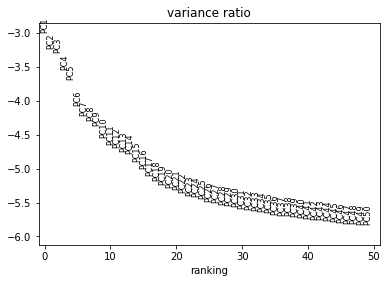

In [139]:
sc.pl.pca_variance_ratio(adata_lymph, n_pcs=50, log=True)

In [ ]:
sc.external.pp.harmony_integrate(adata_lymph, key = ['SampleID', 'tissue', 'group'],
                                 max_iter_harmony=30)

2024-02-21 11:40:31,100 - harmonypy - INFO - Iteration 1 of 30
2024-02-21 11:44:07,340 - harmonypy - INFO - Iteration 2 of 30
2024-02-21 11:47:48,721 - harmonypy - INFO - Iteration 3 of 30
2024-02-21 11:51:23,104 - harmonypy - INFO - Iteration 4 of 30
2024-02-21 11:54:23,247 - harmonypy - INFO - Iteration 5 of 30
2024-02-21 11:57:18,410 - harmonypy - INFO - Iteration 6 of 30


In [ ]:
adata_lymph.write_h5ad('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.lymphocyte.logTP10K.harmonized.h5ad')

In [150]:
adata_lymph

AnnData object with n_obs × n_vars = 202077 × 19842
    obs: 'cellname', 'nCount_RNA', 'nFeature_RNA', 'SampleID', 'percent.mt', 'seurat_clusters', 'cluster', 'celltype', 'tissue', 'group', 'n_counts'
    var: 'Symbol', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'group_colors', 'tissue_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [151]:
sc.pp.neighbors(adata_lymph, n_neighbors=30, n_pcs=36, use_rep='X_pca_harmony')

In [152]:
sc.tl.umap(adata_lymph)

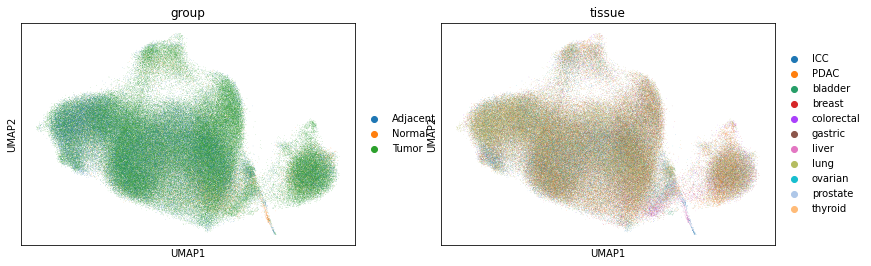

In [153]:
sc.pl.umap(adata_lymph, color=['group', 'tissue'])

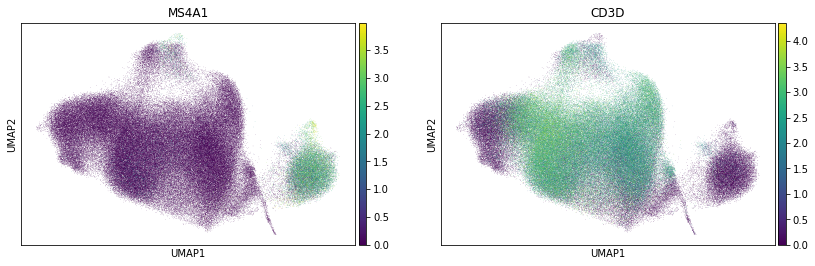

In [157]:
sc.pl.umap(adata_lymph, color=['MS4A1', 'CD3D'], use_raw=False, vmax='p99.9')

In [158]:
sc.tl.leiden(adata_lymph, resolution=1.0)

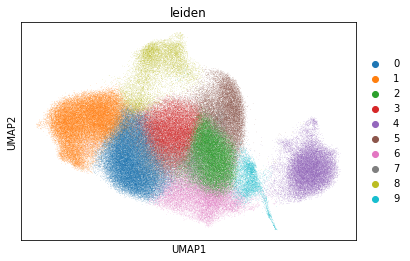

In [160]:
sc.pl.umap(adata_lymph, color=['leiden'])

In [161]:
sc.tl.rank_genes_groups(adata_lymph, groupby='leiden', use_raw=False)

In [174]:
pd.DataFrame(adata_lymph.uns['rank_genes_groups']['names']).head(30)

,0,1,2,3,4,5,6,7,8,9
0,CCL5,GNLY,IL7R,S100A4,HLA-DRA,IL32,MT-CO3,DNAJB1,GAPDH,MT2A
1,CCL4,NKG7,LTB,ANXA1,CD74,S100A4,MT-ATP6,HSPA1A,STMN1,MT1X
2,GZMK,GZMB,RPL34,CCL5,CD79A,BATF,MT-CO2,HSP90AA1,HMGB1,MT1E
3,GZMA,KLRD1,RPL32,IL7R,HLA-DPB1,LTB,MT-ND3,HSPA1B,TUBA1B,FTL
4,NKG7,CCL5,RPS6,VIM,HLA-DPA1,TNFRSF18,MT-ND4,HSPE1,H2AFZ,MT1G
5,CD8A,PRF1,EEF1A1,IL32,HLA-DRB1,TNFRSF4,MT-ND2,HSP90AB1,ACTB,MT1F
6,CST7,TYROBP,RPS27A,ZFP36L2,MS4A1,TIGIT,MT-CO1,JUN,PFN1,FTH1
7,CD8B,CTSW,RPS3A,CD52,HLA-DQB1,TRAC,MT-CYB,HSPH1,HMGB2,IFITM3
8,CCL4L2,CST7,RPS12,CD3D,HLA-DQA1,RGS1,MT-ND1,HSPB1,HMGN2,SERPINA1
9,CD3D,GZMA,RPS18,KLRB1,BANK1,CD3D,MT-ND4L,HSPD1,CFL1,MGST1


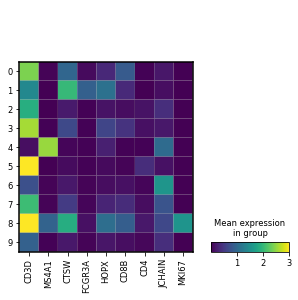

In [176]:
sc.pl.matrixplot(adata_lymph,
                 var_names=['CD3D', 'MS4A1', 'CTSW', 'FCGR3A', 'HOPX', 'CD8B', 'CD4', 'JCHAIN', 'MKI67'],
                 groupby='leiden', vmax=3)

In [178]:
mapper = {0:'T - CD8', 1:'NK', 2:'T - CD4', 3:'T', 4:'B', 5:'T - CD4', 6:'B/Epi', 7:'T', 8:'Proliferating',
          9:'T'}

In [182]:
adata_lymph.obs['leiden1_labeled'] = adata_lymph.obs['leiden'].astype(int).replace(mapper)

In [184]:
sc.tl.leiden(adata_lymph, resolution=2.0)

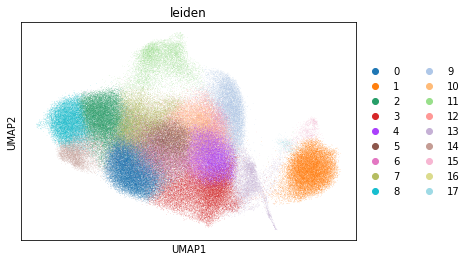

In [187]:
sc.pl.umap(adata_lymph, color=['leiden'])

In [185]:
sc.tl.rank_genes_groups(adata_lymph, groupby='leiden', use_raw=False)

In [192]:
pd.DataFrame(adata_lymph.uns['rank_genes_groups']['names']).head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,CCL5,HLA-DRA,GNLY,MT-CO3,IL7R,CCL5,DNAJB1,CCL5,NKG7,IL32,ANXA1,STMN1,KLRB1,MT2A,TYROBP,CD74,ISG15,HLA-DRA
1,GZMK,CD74,CCL5,MT-ATP6,RPL34,IL7R,HSPA1A,CD3D,GNLY,S100A4,VIM,TUBA1B,RGS1,MT1X,KLRB1,HLA-DRA,IFI6,CD74
2,CCL4,CD79A,NKG7,MT-CO2,LTB,ANXA1,HSP90AA1,S100A4,GZMB,LTB,S100A4,H2AFZ,SRGN,MT1E,NKG7,HLA-DPA1,LY6E,HLA-DPB1
3,GZMA,HLA-DRB1,GZMB,MT-ND2,RPL32,FOS,HSPA1B,TMSB4X,TYROBP,BATF,IL7R,HMGB2,CD3D,FTL,FCER1G,HLA-DRB1,MT2A,HLA-DPA1
4,NKG7,HLA-DPB1,GZMH,MT-ND3,RPS27A,S100A4,HSPE1,IL32,KLRD1,TNFRSF4,LTB,GAPDH,NR3C1,MT1G,CD7,HLA-DPB1,MX1,HLA-DRB1
5,CST7,HLA-DPA1,PRF1,MT-CYB,RPS6,ZFP36L2,JUN,GZMA,PRF1,TNFRSF18,TPT1,HMGB1,CXCL13,MT1F,KLRD1,ACTG1,ISG20,HLA-DQB1
6,CD8A,MS4A1,GZMA,MT-ND4,EEF1A1,VIM,HSP90AB1,GAPDH,FGFBP2,TIGIT,S100A10,TUBB,CD2,IFITM3,TRDC,HLA-DQA1,IFI44L,HLA-DQA1
7,CCL4L2,HLA-DQB1,KLRD1,MT-CO1,RPS3A,CXCR4,HSPH1,SH3BGRL3,CST7,SAT1,LMNA,HMGN2,TRAC,FTH1,XCL2,ACTB,STAT1,CD79A
8,B2M,HLA-DQA1,CTSW,MT-ND1,RPS14,ZFP36,HSPB1,B2M,FCGR3A,IL2RA,CD52,PFN1,S100A4,SERPINA1,CMC1,HLA-DQB1,IFIT3,MS4A1
9,CD8B,BANK1,B2M,MT-ND4L,RPS27,KLRB1,HSPD1,CD8A,KLRF1,TRAC,ZFP36L2,ACTB,RBPJ,MGST1,CTSW,CD79A,TMSB10,CD37


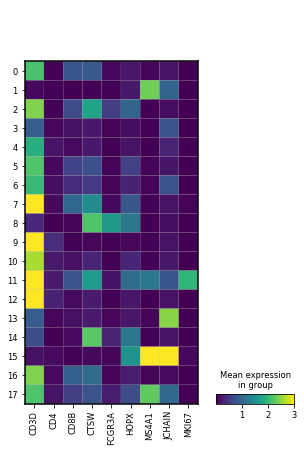

In [190]:
sc.pl.matrixplot(adata_lymph,
                 var_names=['CD3D','CD4','CD8B',  'CTSW', 'FCGR3A', 'HOPX','MS4A1', 'JCHAIN', 'MKI67'],
                 groupby='leiden', vmax=3)

In [193]:
mapper = {0:'T - CD8', 1:'B', 2:'T - CD8', 3:'MThigh_panc', 4:'T - CD4',
          5:'T - CD8', 6:'T - IEG', 7:'T - CD8', 8:'NK',
          9:'T - CD4', 10: 'T - CD4', 11:'Proliferating', 12:'T', 13:'Other',
         14:'NK', 15:'B', 16:'T - CD8', 17: 'B'}

In [195]:
adata_lymph.obs['leiden2_labeled'] = adata_lymph.obs['leiden'].astype(int).replace(mapper)

In [406]:
sc.tl.rank_genes_groups(adata_lymph, groupby='leiden2_labeled', use_raw=False)

In [407]:
pd.DataFrame(adata_lymph.uns['rank_genes_groups']['names']).head(50)

,B,MThigh_panc,NK,Other,Proliferating,T,T - CD4,T - CD8,T - IEG
0,HLA-DRA,MT-CO3,NKG7,MT2A,STMN1,KLRB1,LTB,CCL5,DNAJB1
1,CD74,MT-ATP6,TYROBP,MT1X,TUBA1B,RGS1,IL7R,GZMA,HSPA1A
2,CD79A,MT-CO2,KLRD1,MT1E,H2AFZ,SRGN,S100A4,NKG7,HSP90AA1
3,HLA-DRB1,MT-ND2,GNLY,FTL,HMGB2,CD3D,FXYD5,CCL4,HSPA1B
4,HLA-DPB1,MT-ND3,KLRB1,MT1G,GAPDH,NR3C1,IL32,CD8A,HSPE1
5,HLA-DPA1,MT-CYB,PRF1,MT1F,HMGB1,CXCL13,TPT1,GZMH,JUN
6,MS4A1,MT-ND4,GZMB,IFITM3,TUBB,CD2,TNFRSF4,CD8B,HSP90AB1
7,HLA-DQB1,MT-CO1,FCER1G,FTH1,HMGN2,TRAC,EEF1A1,IL32,HSPH1
8,HLA-DQA1,MT-ND1,KLRF1,SERPINA1,PFN1,S100A4,SPOCK2,CST7,HSPB1
9,BANK1,MT-ND4L,CST7,MGST1,ACTB,RBPJ,TRAC,GZMK,HSPD1


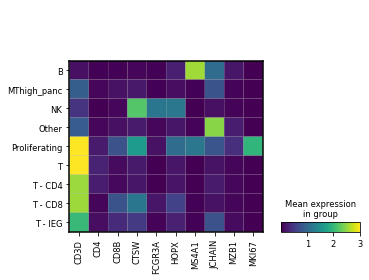

In [410]:
sc.pl.matrixplot(adata_lymph,
                 var_names=['CD3D','CD4','CD8B',  'CTSW', 'FCGR3A', 'HOPX','MS4A1', 'JCHAIN', 'MZB1', 'MKI67'],
                 groupby='leiden2_labeled', vmax=3)

In [196]:
adata_lymph.write_h5ad('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.lymphocyte.logTP10K.harmonized.clustered.h5ad')

In [11]:
adata_lymph = sc.read('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.lymphocyte.logTP10K.harmonized.clustered.h5ad')

Only considering the two last: ['.clustered', '.h5ad'].
Only considering the two last: ['.clustered', '.h5ad'].


In [13]:
lymph_split = pd.crosstab(adata_lymph.obs['SampleID'], adata_lymph.obs['leiden2_labeled'])
lymph_split_sum = lymph_split.sum(axis=1)

In [14]:
lymph_split['T_Total'] = lymph_split[['T', 'T - CD4', 'T - CD8', 'T - IEG']].sum(axis=1)
lymph_split['Other_Total'] = lymph_split[['MThigh_panc', 'Other', 'Proliferating']].sum(axis=1)
lymph_split_summary = lymph_split[['T_Total', 'B', 'NK', 'Other_Total']]
lymph_split_summary.columns = ['T', 'B', 'NK', 'Other']

# Run TCAT on the T-cells

In [15]:
repmap = {'T - IEG':'T', 'Other':'undefined', 'MThigh_panc':'undefined', 'B':'B', 'Proliferating':'undefined', 'T - CD8' :'T', 'T - CD4' :'T', 'NK' :'NK', 'T' :'T'}

adata_lymph.obs['celltype'] = adata_lymph.obs['leiden2_labeled'].replace(repmap)
adata_lymph.obs['celltype'].value_counts()

T            128862
undefined     32812
B             20674
NK            19729
Name: celltype, dtype: int64

In [16]:
t_clusters = ['T - IEG', 'T - CD8', 'T - CD4', 'T']
adata_T = adata_lymph[adata_lymph.obs['celltype']=='T',:]
adata_T_raw = sc.AnnData(X=adata_T.raw.X, var=adata_T.raw.var, obs=adata_T.obs)

In [17]:
adata_T_raw

AnnData object with n_obs × n_vars = 128862 × 19842
    obs: 'cellname', 'nCount_RNA', 'nFeature_RNA', 'SampleID', 'percent.mt', 'seurat_clusters', 'cluster', 'celltype', 'tissue', 'group', 'n_counts', 'leiden', 'leiden1_labeled', 'leiden2_labeled'
    var: 'Symbol', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'

In [18]:
metagepinfo = read_dataset_log('cGEP Paths').loc[0,:]
ref_fn = metagepinfo['tpm_renorm_varnorm_spectra']
hvg_fn = metagepinfo['merged_hvgs']
ref = pd.read_csv(ref_fn, sep='\t', index_col=0)
hvgs = pd.read_csv(hvg_fn, sep='\t', header=None)[0]
ref = ref[hvgs]

In [19]:
gepnameinfo = read_dataset_log('cGEP_Name')
name_dict = dict(zip(gepnameinfo['cGep_Name'], gepnameinfo['Short_Name']))

In [20]:
ref = ref.rename(index=name_dict)

In [21]:
tmod = starcat(tpm_norm=False, copy=True, var_norm=True)
rf_usage = tmod.fit_transform(adata_T_raw, ref_spectra=ref)
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

3409 out of 3412 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [22]:
rf_usage.to_csv('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.T.TCAT.usage.unnormalized.tsv', sep='\t')

In [23]:
rf_usage_norm.head()

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3,CD172a/MERTK,IEG3,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1
cellname,,,,,,,,,,,,,,,,,,,,,
1_nature_AscendingColon1_ACGTTGTGCAATTTCATA,2.522783e-08,1.238105e-08,0.000001,3.830091e-08,2.971806e-07,3.178063e-07,7.865788e-07,6.133100e-07,2.910504e-08,2.848857e-07,...,3.190475e-08,0.000162,1.722885e-08,0.000780,0.000001,6.166587e-07,2.215890e-09,0.000011,0.000066,3.043938e-09
1_nature_AscendingColon1_ACGAGCCATGATAACCTA,4.209282e-06,3.274831e-09,0.000067,2.175749e-07,2.453262e-08,4.860617e-07,4.706153e-07,1.757326e-05,2.485576e-07,1.735583e-03,...,4.230687e-08,0.000157,1.876163e-07,0.000075,0.000012,9.173370e-07,3.874918e-09,0.000008,0.000002,5.762960e-09
1_nature_AscendingColon1_AGGACTATCAACCACAAG,3.268335e-04,8.524844e-06,0.000195,1.485142e-05,3.105380e-04,2.061775e-05,1.555149e-04,4.158362e-04,1.071272e-04,1.044782e-05,...,2.024929e-05,0.001767,1.014346e-05,0.003614,0.013484,1.845951e-04,8.505450e-07,0.002970,0.009506,2.952206e-05
1_nature_AscendingColon1_ACGTTGATGGCGACAATA,1.590652e-06,1.699311e-05,0.000910,1.080788e-06,2.903616e-08,2.233761e-06,4.279039e-05,3.297983e-05,7.052800e-06,9.861946e-06,...,4.228252e-05,0.007060,1.418081e-07,0.002567,0.000746,5.891428e-06,4.377334e-07,0.001089,0.008050,2.181826e-04
1_nature_AscendingColon1_AGGACTATTCCATACTTC,4.305606e-06,5.054219e-07,0.000976,3.530685e-05,1.821343e-05,1.526075e-05,1.071406e-03,7.291794e-05,2.929220e-05,3.271535e-06,...,1.633976e-05,0.007219,7.647666e-08,0.001027,0.000061,5.944457e-06,2.132534e-06,0.001243,0.011674,1.830580e-06


In [24]:
adata_T.write_h5ad('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.lymphocyte.logTP10K.harmonized.clustered.filtT.h5ad')

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [25]:
adata_lymph.write_h5ad('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.lymphocyte.logTP10K.harmonized.clustered.h5ad')

# Compute sample averages and repeat CXCL13 correlation

In [26]:
rf_usage = pd.read_csv('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.T.TCAT.usage.unnormalized.tsv', sep='\t', index_col=0)
rf_usage_norm = rf_usage.div(rf_usage.sum(axis=1), axis=0)

In [27]:
rf_usage

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3,CD172a/MERTK,IEG3,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1
cellname,,,,,,,,,,,,,,,,,,,,,
1_nature_AscendingColon1_ACGTTGTGCAATTTCATA,2.543804e-10,1.248422e-10,1.041286e-08,3.862006e-10,2.996568e-09,3.204544e-09,7.931329e-09,6.184204e-09,2.934755e-10,2.872595e-09,...,3.217060e-10,1.634955e-06,1.737241e-10,7.860801e-06,1.397040e-08,6.217970e-09,2.234354e-11,1.158821e-07,6.680185e-07,3.069301e-11
1_nature_AscendingColon1_ACGAGCCATGATAACCTA,2.246334e-08,1.747653e-11,3.566593e-07,1.161114e-09,1.309212e-10,2.593926e-09,2.511495e-09,9.378179e-08,1.326457e-09,9.262144e-06,...,2.257757e-10,8.401009e-07,1.001237e-09,3.996579e-07,6.288791e-08,4.895479e-09,2.067896e-11,4.415785e-08,1.057415e-08,3.075472e-11
1_nature_AscendingColon1_AGGACTATCAACCACAAG,1.297661e-06,3.384708e-08,7.761678e-07,5.896613e-08,1.232961e-06,8.186082e-08,6.174572e-07,1.651038e-06,4.253385e-07,4.148207e-08,...,8.039789e-08,7.014125e-06,4.027363e-08,1.434818e-05,5.353650e-05,7.329172e-07,3.377008e-09,1.179150e-05,3.774316e-05,1.172145e-07
1_nature_AscendingColon1_ACGTTGATGGCGACAATA,8.063971e-09,8.614831e-08,4.615025e-06,5.479166e-09,1.472017e-10,1.132428e-08,2.169302e-07,1.671946e-07,3.575488e-08,4.999613e-08,...,2.143555e-07,3.579320e-05,7.189104e-10,1.301444e-05,3.783846e-06,2.986719e-08,2.219134e-09,5.520077e-06,4.081204e-05,1.106099e-06
1_nature_AscendingColon1_AGGACTATTCCATACTTC,1.808457e-08,2.122893e-09,4.097409e-06,1.482972e-07,7.650075e-08,6.409881e-08,4.500162e-06,3.062728e-07,1.230342e-07,1.374123e-08,...,6.863091e-08,3.032167e-05,3.212203e-10,4.313005e-06,2.580047e-07,2.496814e-08,8.957154e-09,5.219350e-06,4.903354e-05,7.688873e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_gastric-cancer_6709t1_TTTGCGCAGATGTTAG-1,8.557340e-12,8.285995e-05,1.748246e-08,6.777884e-11,4.897621e-11,2.520166e-08,2.162559e-08,2.801409e-10,1.118322e-08,3.667473e-09,...,9.877647e-09,3.044472e-09,8.621972e-07,7.346315e-05,2.882008e-05,5.808704e-06,2.067958e-06,1.270428e-10,4.928886e-10,1.397288e-08
9_gastric-cancer_6709t1_TTTGGTTTCAGTTAGC-1,1.616111e-08,3.501968e-09,6.365846e-10,1.156794e-07,2.978298e-08,1.157411e-07,5.995008e-07,4.021344e-08,4.759324e-06,1.733986e-07,...,7.857745e-06,1.042360e-05,1.852735e-07,9.988162e-05,9.202134e-08,6.777756e-06,8.979329e-07,4.889243e-06,5.030736e-07,1.133234e-07
9_gastric-cancer_6709t1_TTTGTCACACTATCTT-1,6.598260e-11,2.803565e-07,1.073327e-10,3.689550e-08,3.514801e-10,7.583512e-09,2.754557e-08,2.806320e-08,2.978145e-09,1.372688e-07,...,1.686529e-04,1.115675e-06,5.669834e-08,1.705759e-07,1.796487e-09,7.946870e-08,3.098741e-09,1.635280e-11,1.527978e-10,6.078573e-05


In [28]:
adata_lymph = sc.read('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.lymphocyte.logTP10K.harmonized.clustered.h5ad')
adata = sc.read('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/GSE210347_counts.h5ad')

Only considering the two last: ['.clustered', '.h5ad'].
Only considering the two last: ['.clustered', '.h5ad'].


In [29]:
repmap = {'T - IEG':'T', 'Other':'undefined', 'MThigh_panc':'undefined', 'B':'B', 'Proliferating':'undefined', 'T - CD8' :'T', 'T - CD4' :'T', 'NK' :'NK', 'T' :'T'}
adata.obs['celltype_updated'] = adata.obs['celltype'].astype(str)
ind = adata_lymph.obs.index
adata.obs.loc[ind, 'celltype_updated'] = adata_lymph.obs['leiden2_labeled'].replace(repmap)

celltype = pd.crosstab(adata.obs['SampleID'], adata.obs['celltype_updated'])
celltype['total'] = celltype.sum(axis=1)
sample_info = adata.obs[['SampleID', 'tissue', 'group']].drop_duplicates()
sample_info.index = sample_info['SampleID']
celltype = pd.merge(left=celltype, right=sample_info, left_index=True, right_index=True, how='left')
celltype.head()

,B,Endothelium,Epithelium,Erythrocyte,Fibroblast,Myeloid,NK,Plasma,T,undefined,total,SampleID,tissue,group
SampleID,,,,,,,,,,,,,,
1_nature_AscendingColon1,189,38,128,1,98,66,17,1127,250,290,2204,1_nature_AscendingColon1,colorectal,Normal
1_nature_Bladder1,33,541,61,3,2161,307,10,18,34,106,3274,1_nature_Bladder1,bladder,Normal
1_nature_Bladder2,28,1097,669,7,1536,421,1,99,80,549,4487,1_nature_Bladder2,bladder,Normal
1_nature_Duodenum1,24,300,2082,0,54,244,3,783,118,372,3980,1_nature_Duodenum1,colorectal,Normal
1_nature_GallBladder1,2,237,1061,10,6838,1292,0,21,53,122,9636,1_nature_GallBladder1,bladder,Normal


In [30]:
celltype.to_csv('../../../Data/PerDataset/Pancancer/LuoEtAl_Full/CellTypeCountsPerSample.LymphSplit.tsv', sep='\t')

# Plot Tph correlation with CXCL13

In [31]:
ind = rf_usage_norm.index

X = rf_usage_norm[['Tph', 'Tfh-1', 'Tfh-2']]
X['Combined_Usage'] = X.sum(axis=1)
X['CXCL13'] = adata_lymph[ind, :].obs_vector('CXCL13')

X = pd.merge(left=X, right=adata.obs.loc[ind, ['SampleID', 'tissue', 'group']], left_index=True, right_index=True, how='left')
X[['SampleID', 'tissue', 'group']] = X[['SampleID', 'tissue', 'group']].astype(str)


average_usage = X.groupby(['SampleID', 'tissue', 'group']).mean()[['Tph', 'Tfh-1', 'Tfh-2', 'Combined_Usage', 'CXCL13']].reset_index()
average_usage.head()


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,SampleID,tissue,group,Tph,Tfh-1,Tfh-2,Combined_Usage,CXCL13
0,10_ICC_18adjacent,ICC,Adjacent,0.004760,0.002077,0.003285,0.010122,0.000980
1,10_ICC_18tumor,ICC,Tumor,0.012040,0.005180,0.013726,0.030945,0.032996
2,10_ICC_20tumor,ICC,Tumor,0.012567,0.004365,0.009035,0.025968,0.020151
3,10_ICC_23adjacent,ICC,Adjacent,0.009259,0.004893,0.008560,0.022713,0.072952
4,10_ICC_23tumor,ICC,Tumor,0.026312,0.003839,0.018946,0.049098,0.765601


In [51]:
pearsonr(average_usage.loc[:, 'Tph'], average_usage.loc[:, 'CXCL13'])

(0.6653637567482753, 1.1977071463323267e-30)

In [52]:
ind = average_usage['group']=='Tumor'
pearsonr(average_usage.loc[ind, 'Tph'], average_usage.loc[ind, 'CXCL13'])


(0.6635585431638129, 1.2696308458837676e-19)

In [53]:
ind = average_usage['group']!='Tumor'
pearsonr(average_usage.loc[ind, 'Tph'], average_usage.loc[ind, 'CXCL13'])

(0.3780904871903254, 0.0003602549655157376)

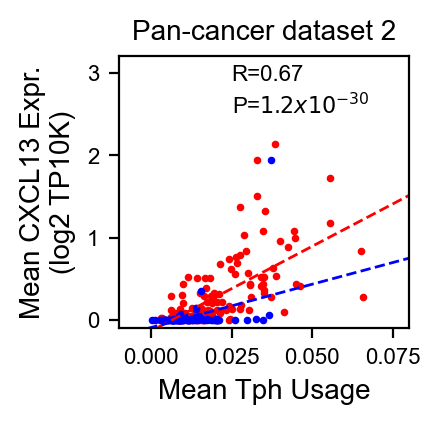

In [56]:
(fig,ax) = plt.subplots(1, 1, figsize=(2.9,2), dpi=200, gridspec_kw={'left':.2, 'bottom':.2, 'right':.7})

tumor_ind = average_usage['group']=='Tumor'

ax.scatter(average_usage.loc[tumor_ind, 'Tph'], average_usage.loc[tumor_ind, 'CXCL13'], label='Tumor', color='r', s=3)
ax.scatter(average_usage.loc[~tumor_ind, 'Tph'], average_usage.loc[~tumor_ind, 'CXCL13'], label='Normal', color='b', s=3)
ax.set_xlabel('Mean Tph Usage', fontsize=10)
ax.set_ylabel('Mean CXCL13 Expr.\n(log2 TP10K)', fontsize=10)
ax.set_title('Pan-cancer dataset 2', fontsize=10)
ax.tick_params(labelsize=8)
ax.set_ylim([-.1, 3.2])
ax.set_xlim([-.01, .08])
#ax.legend(bbox_to_anchor=(1.05,.7), fontsize=8, markerscale=1.5, handletextpad=0, loc=(.02, .74))
R,P = pearsonr(average_usage.loc[:, 'Tph'], average_usage.loc[:, 'CXCL13'])


ax.text(0.025, 2.9, 'R=%.2f' % R, fontsize=8)
ax.text(0.025, 2.5, 'P=$1.2x10^{-30}$' % R, fontsize=8)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

predictor = sm.add_constant(average_usage.loc[tumor_ind, 'Tph'])
res = sm.OLS(endog=average_usage.loc[tumor_ind, 'CXCL13'], exog=predictor).fit()
ypred = res.params.loc['const'] + (res.params.loc['Tph']*np.array(xlim))
ax.plot(xlim, ypred, linestyle='--', color='r', lw=1)

predictor = sm.add_constant(average_usage.loc[~tumor_ind, 'Tph'])
res = sm.OLS(endog=average_usage.loc[~tumor_ind, 'CXCL13'], exog=predictor).fit()
ypred = res.params.loc['const'] + (res.params.loc['Tph']*np.array(xlim))
ax.plot(xlim, ypred, linestyle='--', color='b', lw=1)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig(os.path.join(figdir, 'CancerAssociation.CXCL13.dataset2.Corr.png'))
plt.savefig(os.path.join(figdir, 'CancerAssociation.CXCL13.dataset2.Corr.pdf'))

In [43]:
celltype_merged = pd.merge(left=celltype, right=average_usage.drop(['tissue', 'group'], axis=1), left_index=True, right_on='SampleID', how='left')
celltype_merged.head()


,SampleID,B,Endothelium,Epithelium,Erythrocyte,Fibroblast,Myeloid,NK,Plasma,T,...,total,SampleID_x,tissue,group,SampleID_y,Tph,Tfh-1,Tfh-2,Combined_Usage,CXCL13
47.0,1_nature_AscendingColon1,189,38,128,1,98,66,17,1127,250,...,2204,1_nature_AscendingColon1,colorectal,Normal,1_nature_AscendingColon1,0.008103,0.016657,0.005702,0.030461,0.0
48.0,1_nature_Bladder1,33,541,61,3,2161,307,10,18,34,...,3274,1_nature_Bladder1,bladder,Normal,1_nature_Bladder1,0.007039,0.028394,0.022253,0.057685,0.0
49.0,1_nature_Bladder2,28,1097,669,7,1536,421,1,99,80,...,4487,1_nature_Bladder2,bladder,Normal,1_nature_Bladder2,0.014521,0.033070,0.023721,0.071312,0.0
50.0,1_nature_Duodenum1,24,300,2082,0,54,244,3,783,118,...,3980,1_nature_Duodenum1,colorectal,Normal,1_nature_Duodenum1,0.004422,0.007840,0.002797,0.015059,0.0
51.0,1_nature_GallBladder1,2,237,1061,10,6838,1292,0,21,53,...,9636,1_nature_GallBladder1,bladder,Normal,1_nature_GallBladder1,0.029672,0.005314,0.010777,0.045764,0.0


In [44]:
celltype_merged['frac_plasma'] = celltype_merged['Plasma'] / celltype_merged['total']
celltype_merged['frac_plasma_and_B'] = (celltype_merged['Plasma'] + celltype_merged['B']) / celltype_merged['total']

celltype_merged['plasma_to_T'] = celltype_merged['Plasma'] / celltype_merged['T']
celltype_merged['plasmaAndB_to_T'] = (celltype_merged['Plasma'] + celltype_merged['B']) / celltype_merged['T']

# Plot correlation

In [45]:
celltype_merged['group'].unique()

['Normal', 'Adjacent', 'Tumor']
Categories (3, object): ['Adjacent', 'Normal', 'Tumor']

In [46]:
celltype_merged['group2'] = celltype_merged['group'].replace({'Adjacent':'Normal'})
celltype_merged['group2'].value_counts()

Tumor     148
Normal     86
Name: group2, dtype: int64

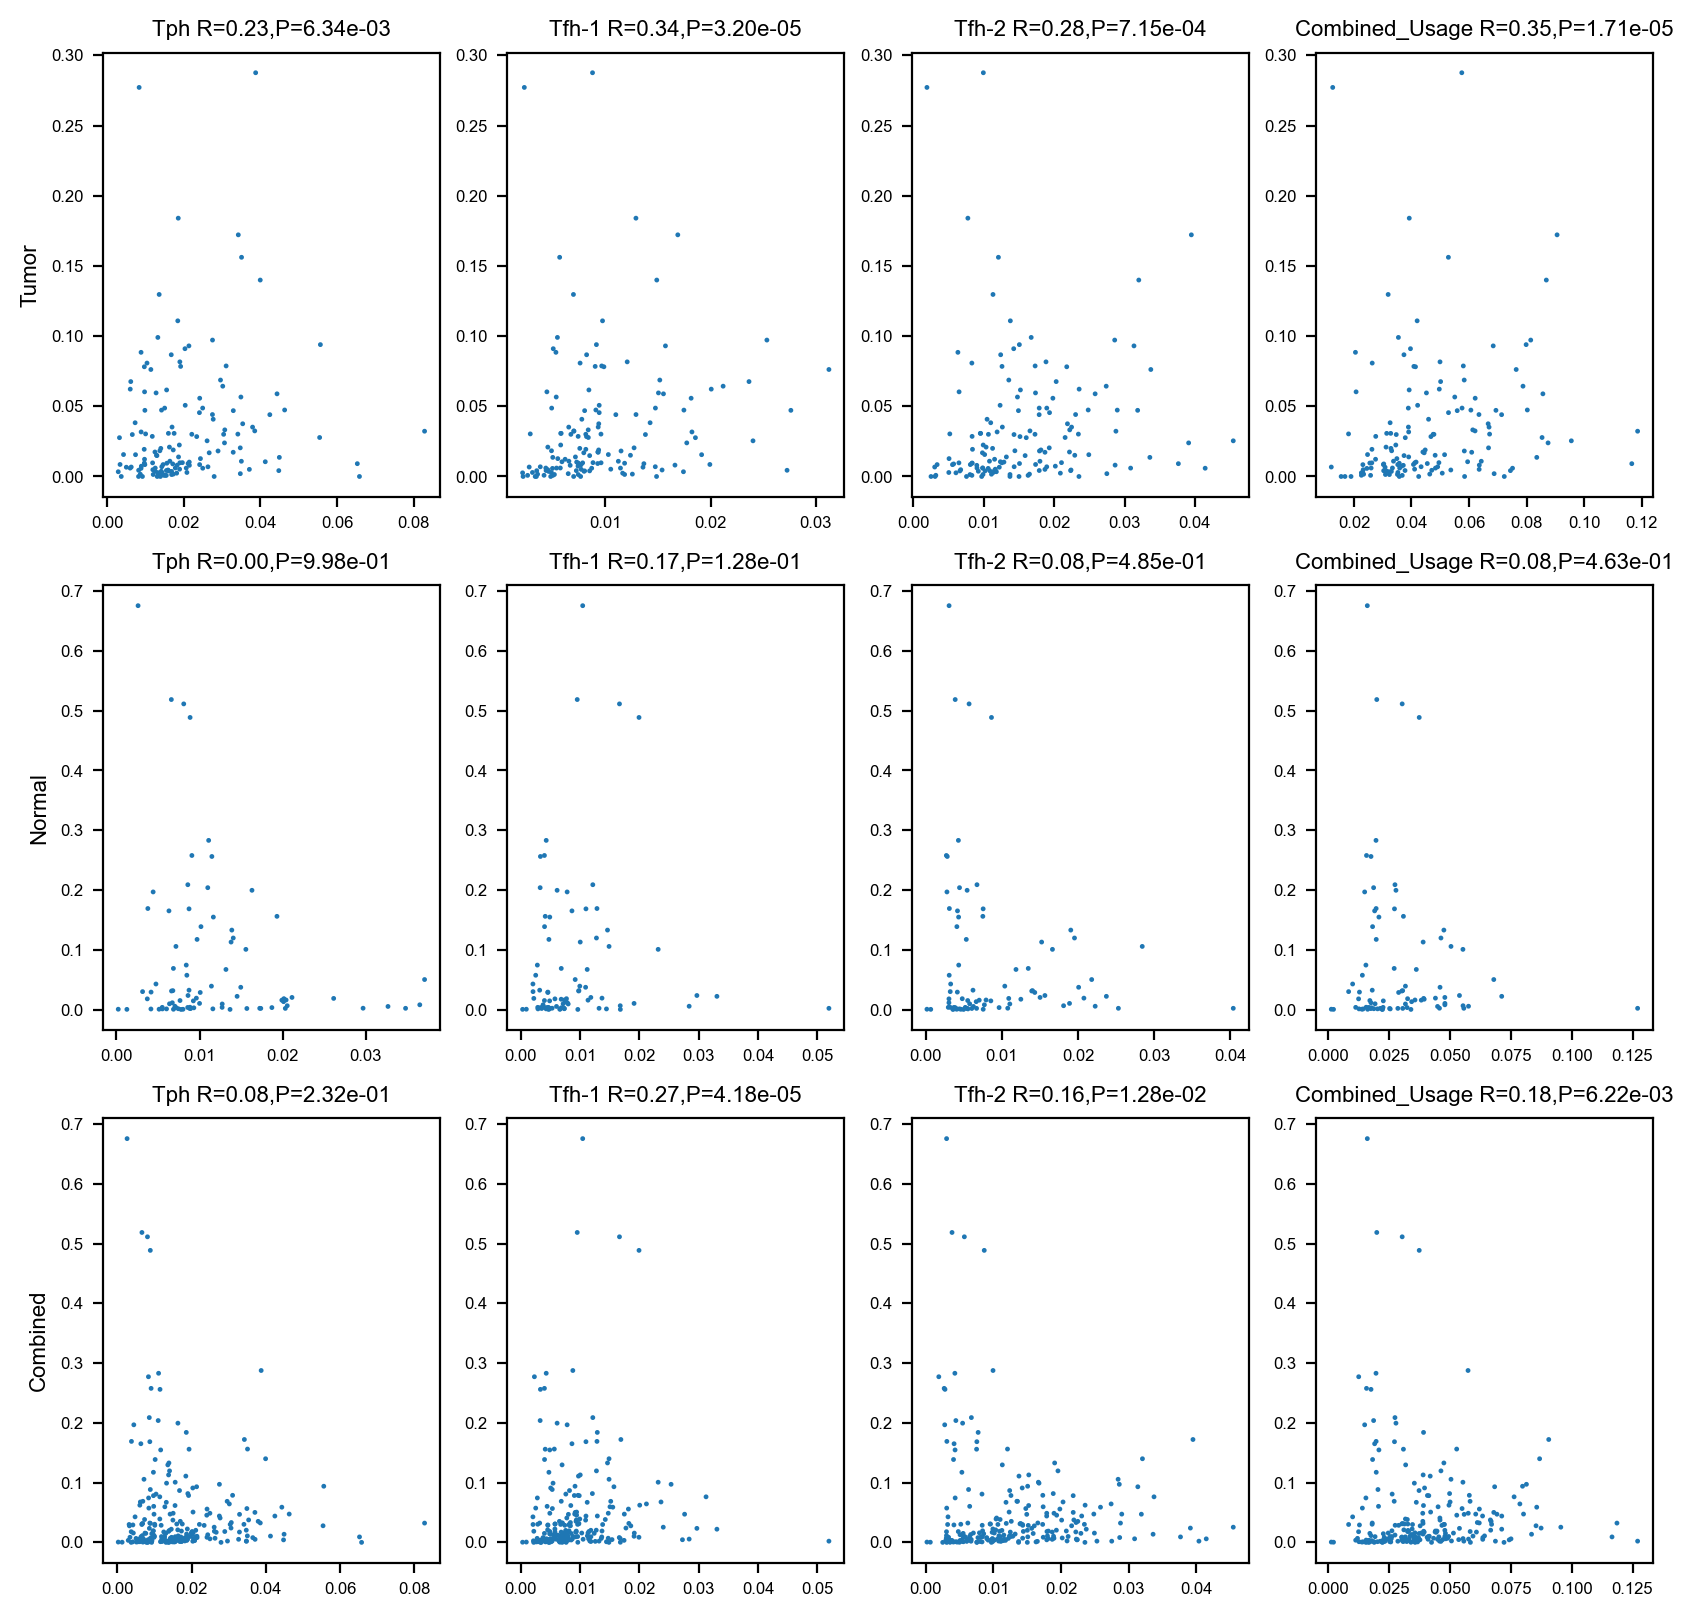

In [50]:
yval = 'frac_plasma'

(fig,axes) = plt.subplots(3, 4, figsize=(10,10), dpi=200)
for i,g in enumerate(['Tumor', 'Normal', 'Combined']):
    for j,gep in enumerate(['Tph', 'Tfh-1', 'Tfh-2', 'Combined_Usage']):
        if g != 'Combined':
            ind = (celltype_merged['group2']==g) & ~celltype_merged[gep].isnull() # & (celltype_merged['tissue']!= 'colorectal')
        else:
            ind =  ~celltype_merged[gep].isnull()            

        x = celltype_merged.loc[ind, gep]
        y = celltype_merged.loc[ind, yval]
        R, P = spearmanr(x, y)
        axes[i,j].scatter(x,y, s=3, edgecolor='None')
        
        if j == 0:
            axes[i,j].set_ylabel(g, fontsize=8)
            
        axes[i,j].set_title('%s R=%.2f,P=%.2e' % (gep, R, P), fontsize=8)
        
        axes[i,j].tick_params(labelsize=6)

In [131]:
ind = (celltype_merged['group']=='Tumor') & ~celltype_merged['Tph'].isnull()
X = sm.add_constant(celltype_merged.loc[ind, ['Tph', 'Tfh-1', 'Tfh-2']])
Y = celltype_merged.loc[ind, 'frac_plasma']

model = sm.OLS(Y, X).fit()  # Fit the model
predictions = model.predict(X)  # Make predictions
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            frac_plasma   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.383
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0720
Time:                        22:53:31   Log-Likelihood:                 241.24
No. Observations:                 144   AIC:                            -474.5
Df Residuals:                     140   BIC:                            -462.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0120      0.010      1.189      0.2

In [132]:
ind = (celltype_merged['group']!='Tumor') & ~celltype_merged['Tph'].isnull()
X = sm.add_constant(celltype_merged.loc[ind, ['Tph', 'Tfh-1', 'Tfh-2']])
Y = celltype_merged.loc[ind, 'frac_plasma']

model = sm.OLS(Y, X).fit()  # Fit the model
predictions = model.predict(X)  # Make predictions
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            frac_plasma   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     3.274
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0252
Time:                        22:53:45   Log-Likelihood:                 59.185
No. Observations:                  85   AIC:                            -110.4
Df Residuals:                      81   BIC:                            -100.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1013      0.027      3.725      0.0

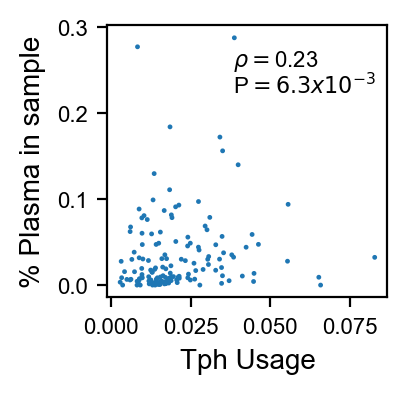

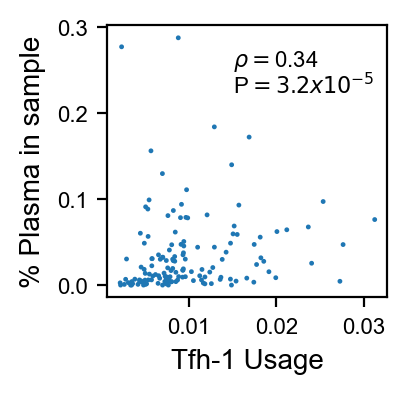

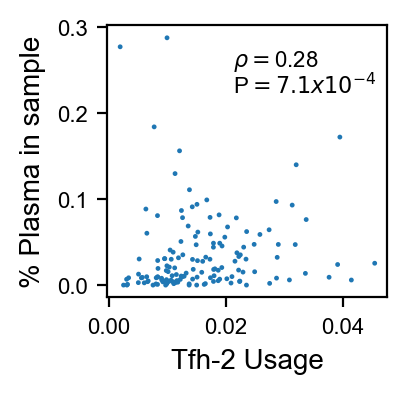

In [140]:
yval = 'frac_plasma'

locmap = [.35, .01, .02]
ind = (celltype_merged['group']=='Tumor') & ~celltype_merged['Tph'].isnull()
for i,gep in enumerate(['Tph', 'Tfh-1', 'Tfh-2']):
    (fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200,
                        gridspec_kw={'left':.28, 'bottom':.2, 'right':0.98})
    x = celltype_merged.loc[ind, gep]
    y = celltype_merged.loc[ind, yval]
    R, P = spearmanr(x, y)
    ax.scatter(x,y, s=3, edgecolor='None') 
    ax.tick_params(labelsize=8)
    ax.set_xlabel(gep + ' Usage', fontsize=10)
    ax.set_ylabel('% Plasma in sample', fontsize=10)
        
    ax.text(.45, .85, r'$\rho=$' + ('%.2f' % R), fontsize=8, transform=ax.transAxes)
    exponent = int(np.floor(np.log10(P)))
    mantissa = P / 10**exponent
    ax.text(.45, .75, 'P$={:.1f}x10^{{{}}}$'.format(mantissa, exponent), fontsize=8, transform=ax.transAxes)
    
    plt.savefig(os.path.join(figdir, 'TphPlasmaAssociation.Tumors.%s.Scatter.png' % gep))
    plt.savefig(os.path.join(figdir, 'TphPlasmaAssociation.Tumors.%s.Scatter.pdf' % gep))

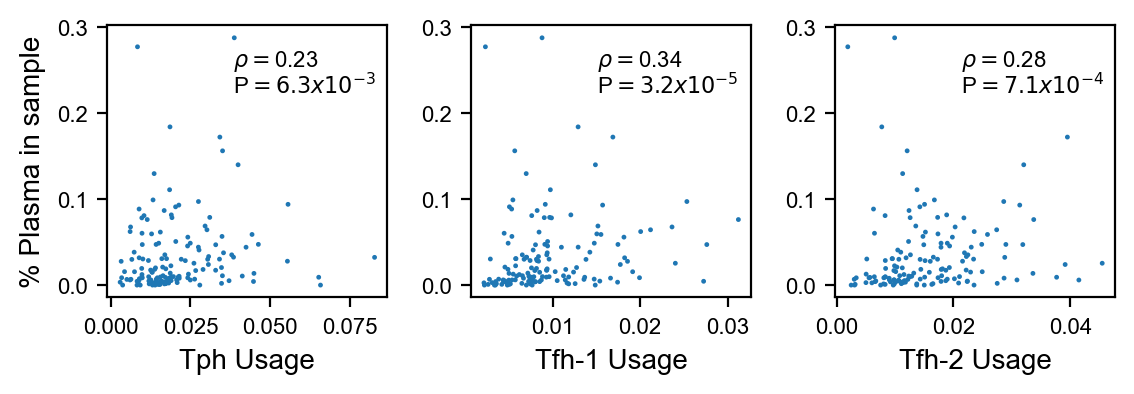

In [543]:
(fig,axes) = plt.subplots(1,3, figsize=(6.5,2), dpi=200, gridspec_kw={'wspace':.3, 'bottom':.2})
yval = 'frac_plasma'

ind = (celltype_merged['group']=='Tumor') & ~celltype_merged['Tph'].isnull()
for i,gep in enumerate(['Tph', 'Tfh-1', 'Tfh-2']):
    x = celltype_merged.loc[ind, gep]
    y = celltype_merged.loc[ind, yval]
    R, P = spearmanr(x, y)
    axes[i].scatter(x,y, s=3, edgecolor='None') 
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel(gep + ' Usage', fontsize=10)
    if i == 0:
        axes[i].set_ylabel('% Plasma in sample', fontsize=10)
        
    axes[i].text(.45, .85, r'$\rho=$' + ('%.2f' % R), fontsize=8, transform=axes[i].transAxes)
    exponent = int(np.floor(np.log10(P)))
    mantissa = P / 10**exponent
    axes[i].text(.45, .75, 'P$={:.1f}x10^{{{}}}$'.format(mantissa, exponent), fontsize=8, transform=axes[i].transAxes)
    
plt.savefig(os.path.join(figdir, 'TphPlasmaAssociation.Tumors.Scatter.png'))
plt.savefig(os.path.join(figdir, 'TphPlasmaAssociation.Tumors.Scatter.pdf'))

In [ ]:
X = sm.add_constant(df['X'])  # Adds a constant term to the predictor
Y = df['Y']

model = sm.OLS(Y, X).fit()  # Fit the model
predictions = model.predict(X)  # Make predictions

# Print out the statistics
print(model.summary())

,B,Endothelium,Epithelium,Erythrocyte,Fibroblast,Myeloid,NK,Plasma,T,undefined,...,tissue,group,Tph,Tfh-1,Tfh-2,Combined_Usage,frac_plasma,frac_plasma_and_B,plasma_to_T,plasmaAndB_to_T
SampleID,,,,,,,,,,,,,,,,,,,,,
1_nature_AscendingColon1,189,38,128,1,98,66,17,1127,250,290,...,colorectal,Normal,0.008103,0.016657,0.005702,0.030461,0.511343,0.597096,4.508000,5.264000
1_nature_Bladder1,33,541,61,3,2161,307,10,18,34,106,...,bladder,Normal,0.007039,0.028394,0.022253,0.057685,0.005498,0.015577,0.529412,1.500000
1_nature_Bladder2,28,1097,669,7,1536,421,1,99,80,549,...,bladder,Normal,0.014521,0.033070,0.023721,0.071312,0.022064,0.028304,1.237500,1.587500
1_nature_Duodenum1,24,300,2082,0,54,244,3,783,118,372,...,colorectal,Normal,0.004422,0.007840,0.002797,0.015059,0.196734,0.202764,6.635593,6.838983
1_nature_GallBladder1,2,237,1061,10,6838,1292,0,21,53,122,...,bladder,Normal,0.029672,0.005314,0.010777,0.045764,0.002179,0.002387,0.396226,0.433962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12_lungcancer_Sample7d,8,154,204,10,32,1190,200,3,766,120,...,lung,Adjacent,0.011605,0.004291,0.004440,0.020335,0.001116,0.004094,0.003916,0.014360
12_lungcancer_Sample8a,38,80,181,3,53,1273,126,49,656,132,...,lung,Tumor,0.017259,0.009381,0.018124,0.044765,0.018912,0.033578,0.074695,0.132622
12_lungcancer_Sample8b,36,84,248,2,65,1655,154,95,700,120,...,lung,Tumor,0.022099,0.008159,0.017278,0.047536,0.030073,0.041469,0.135714,0.187143


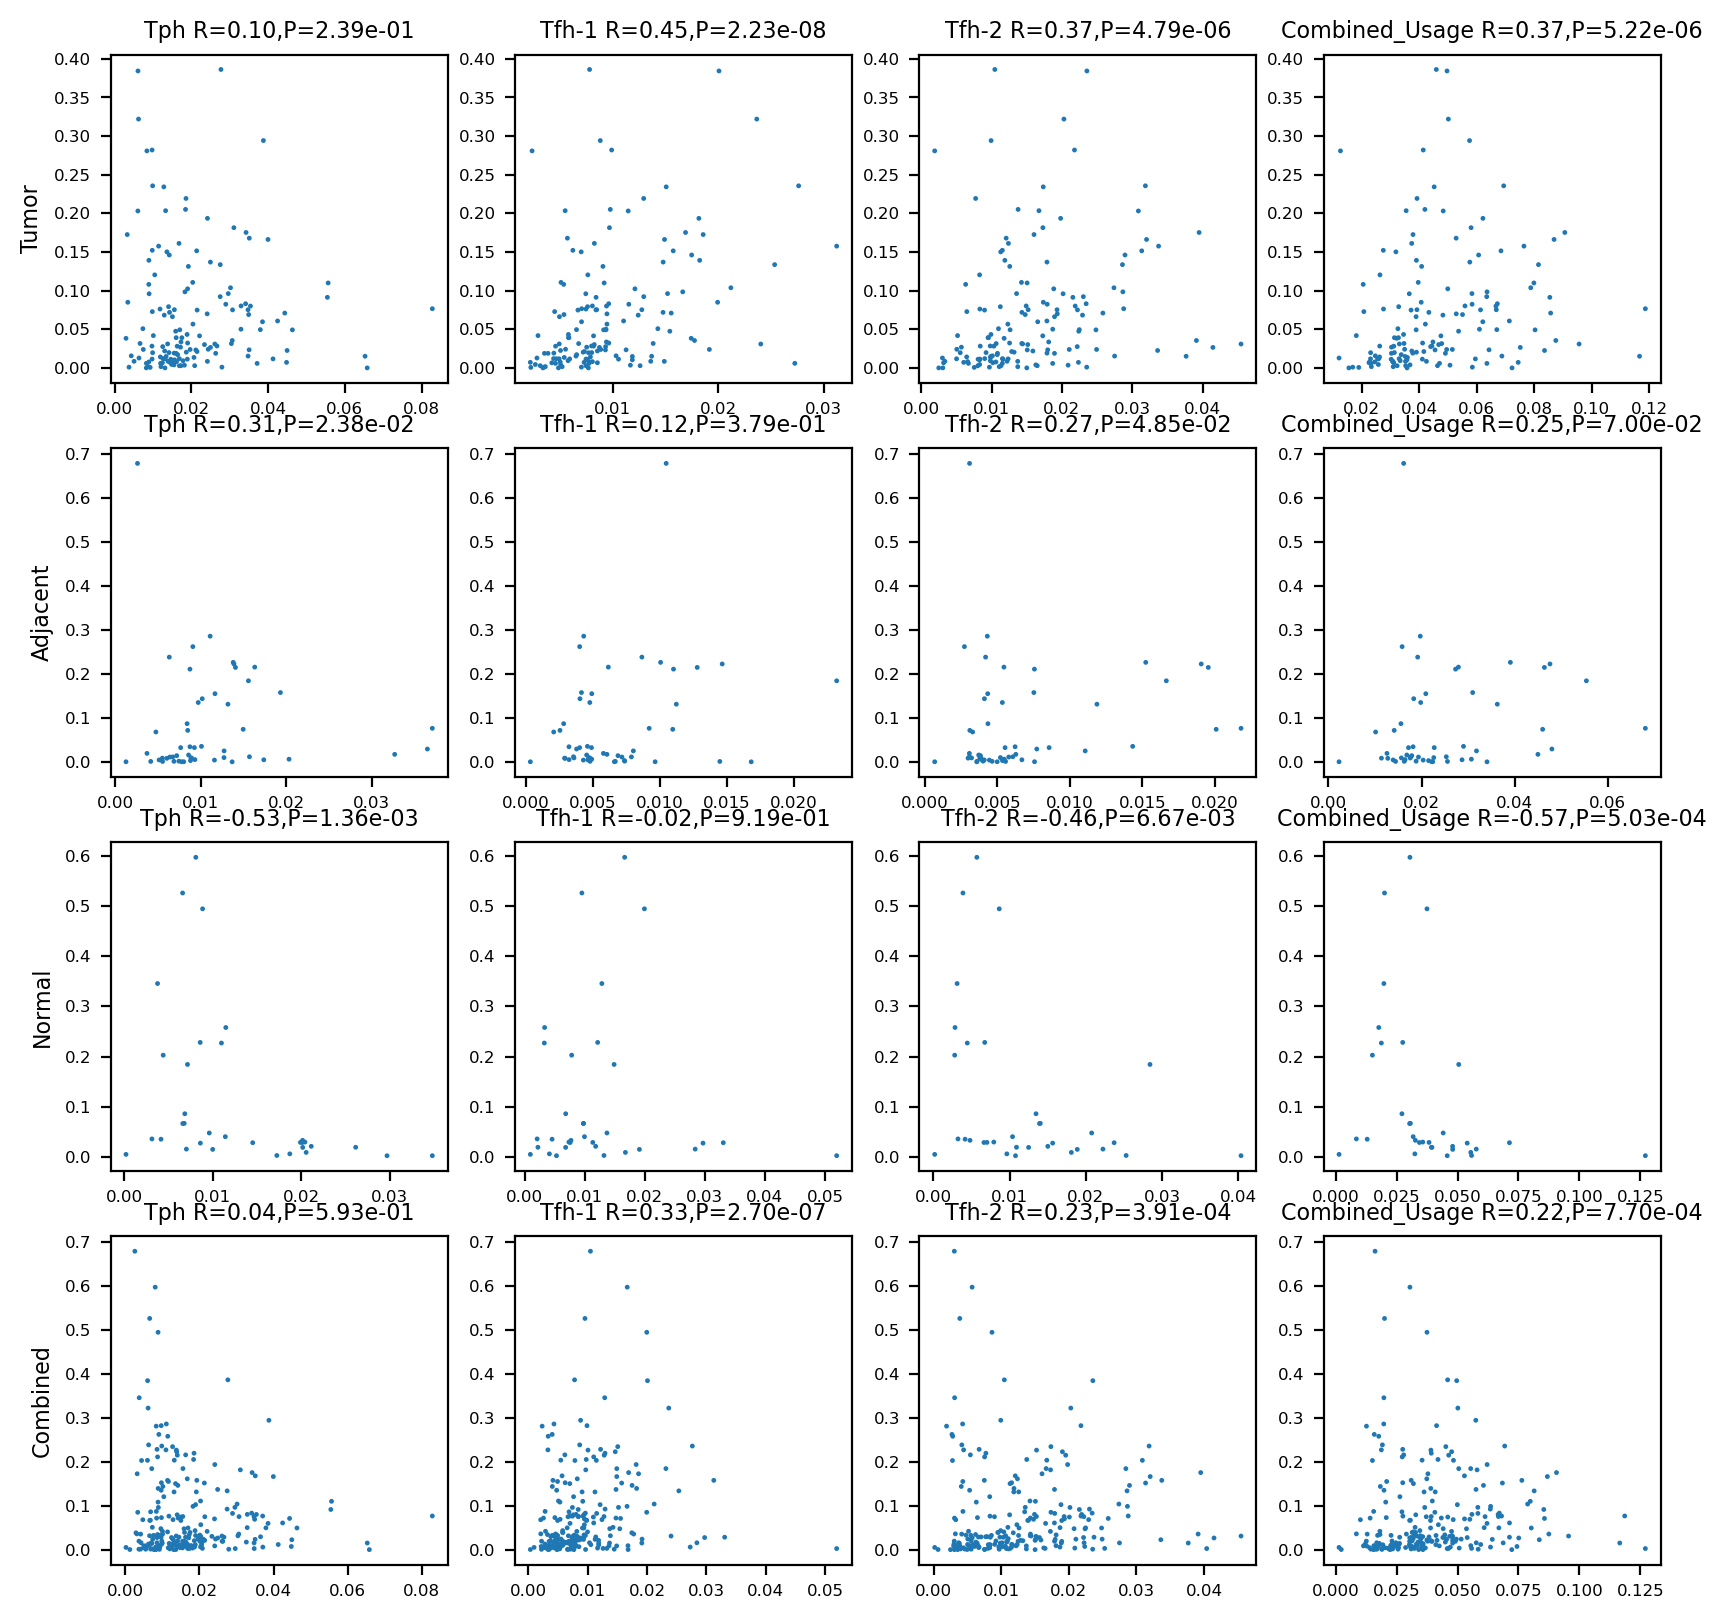

In [492]:
yval = 'frac_plasma_and_B'

(fig,axes) = plt.subplots(4, 4, figsize=(10,10), dpi=200)
for i,g in enumerate(['Tumor', 'Adjacent', 'Normal', 'Combined']):
    for j,gep in enumerate(['Tph', 'Tfh-1', 'Tfh-2', 'Combined_Usage']):
        if g != 'Combined':
            ind = (celltype_merged['group']==g) & ~celltype_merged[gep].isnull() # & (celltype_merged['tissue']!= 'colorectal')
        else:
            ind =  ~celltype_merged[gep].isnull()            

        x = celltype_merged.loc[ind, gep]
        y = celltype_merged.loc[ind, yval]
        R, P = spearmanr(x, y)
        axes[i,j].scatter(x,y, s=3, edgecolor='None')
        
        if j == 0:
            axes[i,j].set_ylabel(g, fontsize=8)
            
        axes[i,j].set_title('%s R=%.2f,P=%.2e' % (gep, R, P), fontsize=8)
        
        axes[i,j].tick_params(labelsize=6)

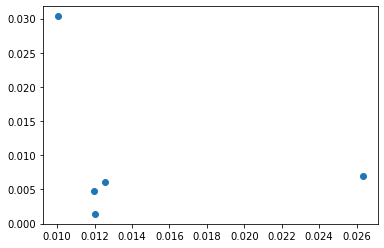

In [487]:
ind =  ~celltype_merged[xval].isnull() & (celltype_merged['group']=='Tumor')
for (k,g) in celltype_merged.loc[ind, :].groupby('tissue'):
    break
    
plt.scatter(g['Tph'], g['frac_plasma'])


In [ ]:
from sta

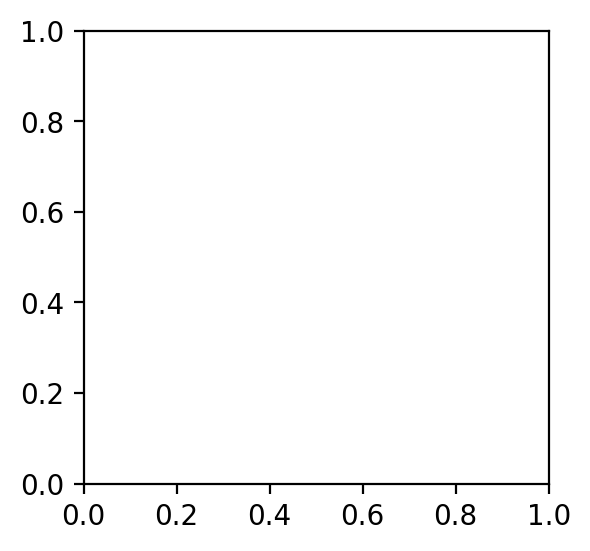

In [479]:
yval = 'frac_plasma'
xval = 'Combined_Usage'
ind =  ~celltype_merged[xval].isnull() # & (celltype_merged['group']=='Normal')
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)


In [480]:
celltype_merged.loc[ind, :].sort_values(by='frac_plasma', ascending=False)

,B,Endothelium,Epithelium,Erythrocyte,Fibroblast,Myeloid,NK,Plasma,T,undefined,...,tissue,group,Tph,Tfh-1,Tfh-2,Combined_Usage,frac_plasma,frac_plasma_and_B,plasma_to_T,plasmaAndB_to_T
SampleID,,,,,,,,,,,,,,,,,,,,,
2_pancancer_scrEXT026,3,15,9,0,188,47,1,627,8,30,...,colorectal,Adjacent,0.002609,0.010461,0.003075,0.016146,0.675647,0.678879,78.375000,78.750000
1_nature_TransverseColon3,25,111,399,0,229,326,6,1769,171,375,...,colorectal,Normal,0.006610,0.009539,0.003879,0.020028,0.518616,0.525945,10.345029,10.491228
1_nature_AscendingColon1,189,38,128,1,98,66,17,1127,250,290,...,colorectal,Normal,0.008103,0.016657,0.005702,0.030461,0.511343,0.597096,4.508000,5.264000
1_nature_TransverseColon2,15,78,455,0,163,283,8,1270,90,237,...,colorectal,Normal,0.008866,0.019947,0.008641,0.037455,0.488649,0.494421,14.111111,14.277778
2_pancancer_scrEXT028,6,66,245,0,145,99,4,260,33,46,...,colorectal,Tumor,0.038752,0.008799,0.009939,0.057490,0.287611,0.294248,7.878788,8.060606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_PDAC_P7,1,12,159,3,151,614,1,0,59,35,...,PDAC,Tumor,0.027932,0.007006,0.023524,0.058462,0.000000,0.000966,0.000000,0.016949
11_prostate-cancer_BC159,1,48,1361,0,37,52,6,0,32,17,...,prostate,Tumor,0.009224,0.002209,0.007544,0.018977,0.000000,0.000644,0.000000,0.031250
11_prostate-cancer_BC162,0,189,3577,0,6,1509,8,0,10,3,...,prostate,Tumor,0.013087,0.007669,0.015009,0.035765,0.000000,0.000000,0.000000,0.000000


SpearmanrResult(correlation=0.2264718564278252, pvalue=0.0063423708603504245)

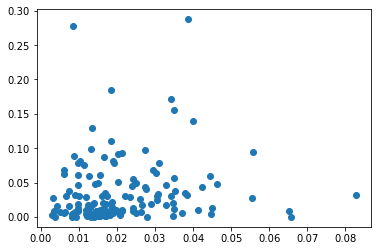

In [386]:
xval = 'Tph'
yval = 'frac_plasma'
ind =  (allresults_split['group']=='Tumor') & ~allresults_split[xval].isnull()
#ind =  ~allresults_split[xval].isnull()

x = allresults_split.loc[ind, xval]
y = allresults_split.loc[ind, yval]


plt.scatter(x, y)
spearmanr(x, y)

SpearmanrResult(correlation=0.3391983510767663, pvalue=3.1980424955780955e-05)

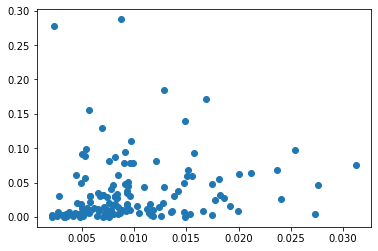

In [389]:
xval = 'Tfh2'
yval = 'frac_plasma'
ind =  (allresults_split['group']=='Tumor') & ~allresults_split[xval].isnull()
#ind =  ~allresults_split[xval].isnull()

x = allresults_split.loc[ind, xval]
y = allresults_split.loc[ind, yval]


plt.scatter(x, y)
spearmanr(x, y)

SpearmanrResult(correlation=0.07936919150922997, pvalue=0.23154459000636474)

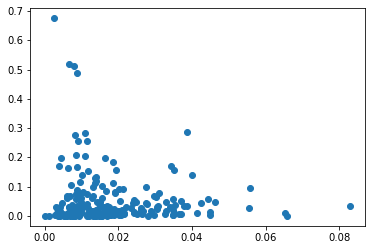

In [390]:
xval = 'Tph'
yval = 'frac_plasma'
ind =  ~allresults_split[xval].isnull()
#ind =  ~allresults_split[xval].isnull()

x = allresults_split.loc[ind, xval]
y = allresults_split.loc[ind, yval]


plt.scatter(x, y)
spearmanr(x, y)

SpearmanrResult(correlation=0.1642249560044019, pvalue=0.012828552242465423)

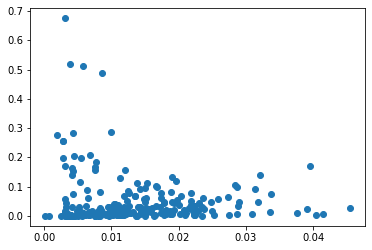

In [391]:
xval = 'Tfh'
yval = 'frac_plasma'
ind =  ~allresults_split[xval].isnull()
#ind =  ~allresults_split[xval].isnull()

x = allresults_split.loc[ind, xval]
y = allresults_split.loc[ind, yval]


plt.scatter(x, y)
spearmanr(x, y)

SpearmanrResult(correlation=0.26728369172476624, pvalue=4.178240675625419e-05)

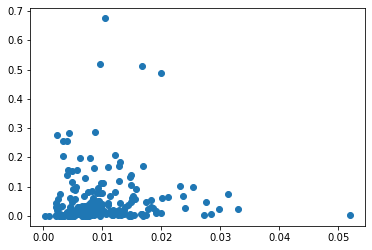

In [393]:
xval = 'Tfh2'
yval = 'frac_plasma'
ind =  ~allresults_split[xval].isnull()
#ind =  ~allresults_split[xval].isnull()

x = allresults_split.loc[ind, xval]
y = allresults_split.loc[ind, yval]


plt.scatter(x, y)
spearmanr(x, y)

In [ ]:
& (allresults_split['pct_epithelium']>.3)

In [367]:
from scipy.stats import spearmanr

In [320]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [321]:
sc.pp.log1p(adata)

In [323]:
sc.tl.rank_genes_groups(adata, groupby='celltype')

In [328]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

,Endothelium,Epithelium,Erythrocyte,Fibroblast,Lymphocyte,Myeloid,Plasma,undefined
0,SPARCL1,KRT18,HBB,DCN,CXCR4,TYROBP,JCHAIN,IL7R
1,GNG11,KRT8,HBA2,LGALS1,CD52,FCER1G,IGKC,IGKC
2,IFI27,SPINT2,HBA1,MGP,BTG1,FTL,MZB1,TG
3,RAMP2,EPCAM,COL1A1,CALD1,CCL5,HLA-DRA,SSR4,LTB
4,IGFBP7,KRT19,COL1A2,COL1A2,CD3D,AIF1,IGHA1,MALAT1
5,A2M,TACSTD2,COL3A1,IGFBP7,B2M,FTH1,DERL3,JCHAIN
6,IFITM3,ELF3,TAGLN,SPARC,CORO1A,LYZ,FKBP11,RPL9P9
7,PLVAP,CLDN4,ACTA2,IFITM3,IL32,CD74,IGLC2,MT-RNR2
8,EPAS1,CD24,RPS18,LUM,PTPRC,SRGN,CD79A,IGHA1
9,PECAM1,PERP,SPARC,COL3A1,CD2,HLA-DRB1,IGHA2,MS4A1


In [91]:
meta.index = meta['cellname']

In [86]:
cells

0             1,1_nature_AscendingColon1_AACCTATAGCATACCTGA
1             2,1_nature_AscendingColon1_ACGTTGTGCAATTTCATA
2             3,1_nature_AscendingColon1_CTCGCAACTTATGACACT
3             4,1_nature_AscendingColon1_CTCGCACAACAAACCTGA
4             5,1_nature_AscendingColon1_CTCGCACTCCATCAACAA
                                ...                        
855266    855267,9_gastric-cancer_6709t1_TTTGTCACACTATCTT-1
855267    855268,9_gastric-cancer_6709t1_TTTGTCACATCCCACT-1
855268    855269,9_gastric-cancer_6709t1_TTTGTCATCCTTTACA-1
855269    855270,9_gastric-cancer_6709t1_TTTGTCATCGAACTGT-1
855270    855271,9_gastric-cancer_6709t1_TTTGTCATCTTCCTTC-1
Name: ,colnames(data), Length: 855271, dtype: object

In [ ]:
mmread

# Scratch

Download esophagus carcinoma data from GEO
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145370

In [17]:
! ls -lah ../../../Data/PerDataset/Pancancer/FromGEO

total 668M
drwxrwx---. 3 dk718 srlab 4.0K Feb 20 19:12 .
drwxrwx---. 7 dk718 srlab 8.0K Feb 20 19:12 ..
-rw-rw----. 1 dk718 srlab 534M Feb 20 19:19 GSE145370_RAW.tar
drwxrwx---. 2 dk718 srlab 4.0K Feb 20 19:05 .ipynb_checkpoints
